# Финальный проект

## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

* При выполнении тестового задания необходимо использовать язык программирования Python. 
* В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
* Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Дана таблица `default.peas`:

Название атрибута | Тип атрибута | Смысловое значение
------------------|--------------|-------------------
st_id | int | ID ученика
timest | timestamp | Время решения карточки
correct | bool | Правильно ли решена горошина?
subject | text | Дисциплина, в которой находится горошина

Необходимо написать <ins>оптимальный запрос</ins>, который даст информацию о количестве очень усердных студентов.

*NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.*

### 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: `default.peas` (см. выше), `default.studs`:

Название атрибута | Тип атрибута |Смысловое значение
------------------|--------------|-------------------
st_id|	int |	ID ученика
test_grp	|text 	|Метка ученика в данном эксперименте

и `default.final_project_check`:


Название атрибута	|Тип атрибута 	|Смысловое значение
------------------|--------------|-------------------
st_id|	int |	ID ученика
sale_time|	timestamp	|Время покупки
money|	int	|Цена, по которой приобрели данный курс
subject|	text |	Дисциплина, на которую приобрели полный доступ

Необходимо <ins>в одном запросе</ins> выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший **больше** 10 задач правильно в любых дисциплинах.

**Активным** по математике считается пользователь, за все время решивший **2 или больше задач** правильно по математике.

## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

-------------------------------

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

from tqdm.auto import tqdm
from scipy.stats import norm 

import seaborn as sns
import matplotlib.pyplot as plt

import re

Далее, загрузим датасеты:

In [2]:
# получаем прямую ссылку на файлы
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


# ссылки на данные с указанием разделителя csv-файла
links_dic = {
    'groups':       ['https://disk.yandex.ru/d/FE66RUnHl0ZSQg', ';'],
    'groups_add':   ['https://disk.yandex.ru/d/X0T1LNLKgEe9lw', ','],
    'active_studs': ['https://disk.yandex.ru/d/g9bM7B3gR3yhHw', ','],
    'checks':       ['https://disk.yandex.ru/d/FtcqllhS_CFwNw', ';']
            }

# скачиваем файлы
for csv_filename, csv_link in links_dic.items():
    final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
    response                = requests.get(final_url)
    download_url            = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])

Посмотрим на данные:

In [3]:
print(groups.head(),                              '\n')
print(groups.info(),                              '\n')
print('Уникальных ID в датасете:', groups.id.nunique())

     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None 

Уникальных ID в датасете: 74484


In [4]:
print(groups_add.head(),                              '\n')
print(groups_add.info(),                              '\n')
print('Уникальных ID в датасете:', groups_add.id.nunique())

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None 

Уникальных ID в датасете: 92


In [5]:
print(active_studs.head(),                                      '\n')
print(active_studs.info(),                                      '\n')
print('Уникальных ID в датасете:', active_studs.student_id.nunique())

   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None 

Уникальных ID в датасете: 8341


In [6]:
print(checks.head(),                                      '\n')
print(checks.info(),                                      '\n')
print('Уникальных ID в датасете:', checks.student_id.nunique())

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None 

Уникальных ID в датасете: 541


----------------
Проверим, учтены ли данные из `groups_add` в `active_studs` и `checks`:

In [7]:
print('Количество учтенных ID в active_studs:', groups_add.query('id in @active_studs.student_id').shape[0], 
      '\nКоличество учтенных ID в checks:',     groups_add.query('id in @checks.student_id').shape[0])

Количество учтенных ID в active_studs: 13 
Количество учтенных ID в checks: 1


Соединим датафрейм `groups` c датафреймом `groups_add`, т.к. второй является дополнением первого:

In [8]:
groups_total = pd.concat([groups, groups_add])
print('Количество строк было:', groups_add.id.count() + groups.id.count(), 
      '\nКоличество строк после соединения:', pd.concat([groups, groups_add]).id.count(),
      '\nВсе верно' if groups_add.id.count() + groups.id.count() == groups_total.id.count()
                    else '\nНеверное количество')

Количество строк было: 74576 
Количество строк после соединения: 74576 
Все верно


In [9]:
print('Распределение всех пользователей по группам: \nГруппа A:', 
      groups_total.grp.value_counts()[1], '\nГруппа B:',
      groups_total.grp.value_counts()[0], '\nВсего:   ',
      groups_total.grp.value_counts()[1] +
      groups_total.grp.value_counts()[0])

Распределение всех пользователей по группам: 
Группа A: 14693 
Группа B: 59883 
Всего:    74576


In [10]:
paid_not_active = checks.query('student_id not in @active_studs.student_id')
print('Количество пользователей из списка активных, но не вошедших в общий список:', 
      active_studs.query('student_id not in @groups_total.id').shape[0],
      '\nКоличество оплативших пользователей, отсутствующих в общем списке:',
      checks.query('student_id not in @groups_total.id').shape[0],
      '\nКоличество оплативших пользователей, отсутствующих в списке активных в дни проведения теста:',
      paid_not_active.shape[0])

Количество пользователей из списка активных, но не вошедших в общий список: 0 
Количество оплативших пользователей, отсутствующих в общем списке: 0 
Количество оплативших пользователей, отсутствующих в списке активных в дни проведения теста: 149


-------------
Получается, что в период проведения экспериментов были оплаты и от тех студентов, которые не посещали платформу. Возможно, это автоматические оплаты.

In [11]:
print('Распредление checks по группам: \nГруппа A:', 
      groups_total.query('id in @checks.student_id').grp.value_counts()[0], '\nГруппа B:',
      groups_total.query('id in @checks.student_id').grp.value_counts()[1], '\nВсего:   ', 
      groups_total.query('id in @checks.student_id').grp.value_counts()[0] + 
      groups_total.query('id in @checks.student_id').grp.value_counts()[1])

Распредление checks по группам: 
Группа A: 434 
Группа B: 107 
Всего:    541


In [12]:
print('Оплатили, но не в списке активных, количество по группам:\nГруппа A:', 
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[0], '\nВсего:   ',
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[1] + 
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[0])

Оплатили, но не в списке активных, количество по группам:
Группа A: 29 
Группа B: 120 
Всего:    149


In [13]:
print('Распределение active_studs по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[0], '\nВсего:   ',
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[1] + 
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[0])

Распределение active_studs по группам: 
Группа A: 1538 
Группа B: 6803 
Всего:    8341


In [14]:
print('Активные оплатившие пользователи, количество по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[0], '\nВсего:   ',
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[1] +
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[0])

Активные оплатившие пользователи, количество по группам: 
Группа A: 78 
Группа B: 314 
Всего:    392


In [15]:
print('Активные, но не оплатившие пользователи, количество по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[0], '\nВсего:   ',
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[1] +
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[0])

Активные, но не оплатившие пользователи, количество по группам: 
Группа A: 1460 
Группа B: 6489 
Всего:    7949


Подвем небольшой итог изобразив проанализированную информацию в виде диаграммы Эйлера-Венна:

![](https://raw.githubusercontent.com/IgorAgarkov/karpov_courses/c4fe3796970da1728e40b27034594bdb24d21c1f/final_project/img/oval_diagram.png)

Итак, у нас есть активные пользователи, те, что заходили на сайт в дни проведения теста и есть пользователи, которые совершили платежи. Активные с оплатившими пересекаются только частично, отсюда возникает вопрос: кто те пользователи, которые оплатили, но не попали в список активных? Из постановки задачи это не ясно, возможно это автоматические платежи, а возможно сбой системы и все оплатившие являются активными. Так как у нас нет возможности прояснить это, уберём из выборки оплативших не активных. Т.е. оплативших будем брать только тех, одновременно является и оплатившим, и активным (пересечение `active_studs` и `checks` - 392 человека).

Пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А.

----------------------------------

Объединим список активных пользователей со списком оплативших, отбросив из последних тех, кого нет в списке активных:

In [16]:
active_checks = (
                active_studs
                .merge(checks, how='left', on='student_id')
                .rename(columns={'student_id': 'id'})
                )
active_checks.query('rev.notna()').head()

,id,rev
62,1184303,1530.0000
67,3354191,1900.0001
77,3278734,1900.0000
99,720651,1980.0000
193,1232221,1900.0000


Объединим активных оплативших из предыдущего шага с `groups_total`, оставив только активных:

In [17]:
active_total = groups_total.merge(active_checks, how='right', on='id')

Добавим колонку со статусом оплаты (0 - не оплачен, 1 - оплачен):

In [18]:
active_total['payment'] = active_total.rev.apply(lambda x: 0 if np.isnan(x) else 1)
active_total.query('rev.isna()').head()

,id,grp,rev,payment
0,581585,A,NaN,0
1,5723133,A,NaN,0
2,3276743,B,NaN,0
3,4238589,A,NaN,0
4,4475369,B,NaN,0


Заменим NaN на нули:

In [19]:
active_total['rev'] = active_total.rev.fillna(0)

Сформируем датафрейм со всей собранной информацией.
Активные + оплатившие:

In [20]:
active_total_paid = active_total.query('rev > 0')
active_total_paid.head()

,id,grp,rev,payment
62,1184303,A,1530.0000,1
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
99,720651,A,1980.0000,1
193,1232221,B,1900.0000,1


Группа А:

In [21]:
a_group = active_total.query('grp == "A"')
a_group.head()

,id,grp,rev,payment
0,581585,A,0.0,0
1,5723133,A,0.0,0
3,4238589,A,0.0,0
7,1394612,A,0.0,0
21,5194768,A,0.0,0


Активные оплатившие пользователи, группа А:

In [22]:
a_group_paid = a_group.query('rev > 0')
a_group_paid.head()

,id,grp,rev,payment
62,1184303,A,1530.0,1
99,720651,A,1980.0,1
306,4337103,A,580.0,1
392,332387,A,2910.0,1
439,1659434,A,690.0,1


Активные пользователи, группа B:

In [23]:
b_group = active_total.query('grp == "B"')
b_group.head()

,id,grp,rev,payment
2,3276743,B,0.0,0
4,4475369,B,0.0,0
5,5481015,B,0.0,0
6,1353433,B,0.0,0
8,1170611,B,0.0,0


Активные оплатившие пользователи, группа B:

In [24]:
b_group_paid = b_group.query('rev > 0')
b_group_paid.head()

,id,grp,rev,payment
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
193,1232221,B,1900.0000,1
195,3821501,B,1900.0000,1
211,1036096,B,1900.0000,1


--------------
Распределение группы А (все пользователи):

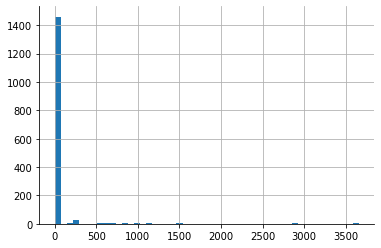

In [25]:
a_group.rev.hist(bins=50)
sns.despine()

Распределение группы В (все пользователи):

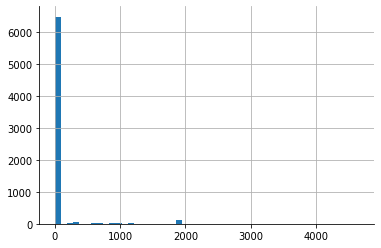

In [26]:
b_group.rev.hist(bins=50)
sns.despine()

Распределение группы А (только купившие):

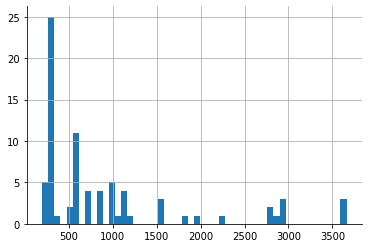

In [27]:
a_group_paid.rev.hist(bins=50)
sns.despine()

Распределение группы В (только купившие):

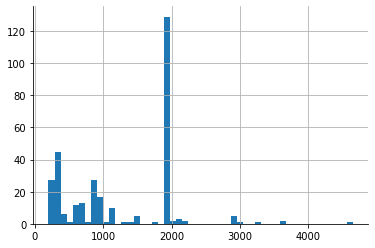

In [28]:
b_group_paid.rev.hist(bins=50)
sns.despine()

Сравним описательную статистику по всем пользователям в двух группах:

In [29]:
a_group_descr = a_group.rev.describe().to_frame().rename(columns={'rev': 'Группа В'})
b_group_descr = b_group.rev.describe().to_frame().rename(columns={'rev': 'Группа А'})
pd.concat([a_group_descr, b_group_descr], axis=1)

,Группа В,Группа А
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


Сравним описательную статистику по оплатившим пользователям в двух группах:

In [30]:
a_group_descr = a_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Группа А'})
b_group_descr = b_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Группа В'})
pd.concat([a_group_descr, b_group_descr], axis=1)

,Группа А,Группа В
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


Посмотрим на выборосы (все пользователи):

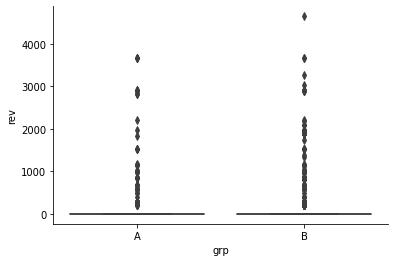

In [31]:
sns.boxplot(data=active_total, y='rev', x='grp')
sns.despine()

Посмотрим на выборосы (купившие):

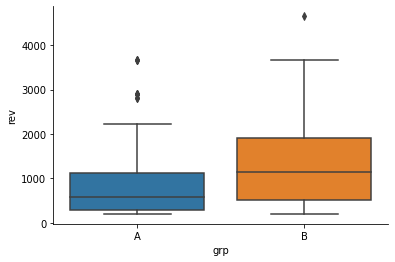

In [32]:
sns.boxplot(data=active_total_paid, y='rev', x='grp')
sns.despine()

Считаю, что следует выбрать следующие метрики:

* `CR` (конверсия онлайн платежей) - отношение количества оплативших клиентов к общему числу активных клиентов.
Может отражать юзабилити новой механики оплаты. Например часть пользователей не оплачивают т.к. сталкиваются с трудностями при оплате. Следовательно, CR выше в том варианте, где пользователю проще проивзести оплату.
* `ARPU` - отношение общей суммы на количество активных пользователей.
Важный показатель для бизнеса, при увеличении этого показателя бизнес получает больше денег.
* `ARPPU` - отношение общей суммы на количество активных оплативших пользователей.
Причины выбора этой метрики такие же, как и в случае с ARPU.


In [33]:
print('\033[1mCR \033[0m\nКонверсия оплативших пользователей:\nГруппа А:', 
                                             round(a_group_paid.id.count() / a_group.id.count(), 4),
                                             '\nГруппа В:', 
                                             round(b_group_paid.id.count() / b_group.id.count(), 4),
      '\nКонверсия у группы B на', abs(round((round(b_group_paid.id.count() / b_group.id.count(), 4) - 
                                   round(a_group_paid.id.count() / a_group.id.count(), 4)) / 
                                   round(a_group_paid.id.count() / a_group.id.count(), 4), 3) * 100), '%',
      'больше, чем у группы А' if round((round(b_group_paid.id.count() / b_group.id.count(), 4) - 
                                  round(a_group_paid.id.count() / a_group.id.count(), 4)) / 
                                  round(a_group_paid.id.count() / a_group.id.count(), 4), 3) * 100 > 0 
                               else 'меньше, чем у группы А')

print('\n\033[1mARPPU \033[0m\nОтношение общей суммы на количество активных оплативших пользователей:\nГруппа А:',
                                                                                      round(a_group_paid.rev.mean(), 2), 
                                                                                     '\nГруппа В:', 
                                                                                      round(b_group_paid.rev.mean(), 2),
      '\nARPPU группы В на', round(round(b_group_paid.rev.mean() - a_group_paid.rev.mean(), 2) /
                             round(a_group_paid.rev.mean(), 2) * 100, 2),'%',
      'больше, чем у группы А' if round(round(b_group_paid.rev.mean() - a_group_paid.rev.mean(), 2) /
                                  round(a_group_paid.rev.mean(), 2) * 100, 2) > 0 
                               else 'меньше, чем у группы А/n')

print('\n\033[1mARPU\033[0m\nОтношение общей суммы на количество активных пользователей:\nГруппа А:',
                                                                          round(a_group_paid.rev.sum() / a_group.id.count(), 2),
                                                                          '\nГруппа В:', 
                                                                          round(b_group_paid.rev.sum() / b_group.id.count(), 2),
      '\nARPU группы В на', 
      round((round(b_group_paid.rev.sum() / b_group.id.count(), 2) - round(a_group_paid.rev.sum() / a_group.id.count(), 2)) /
      round(a_group_paid.rev.sum() / a_group.id.count(), 2) * 100, 2), '%',
      'больше, чем у группы А' if 
      round((round(b_group_paid.rev.sum() / b_group.id.count(), 2) - round(a_group_paid.rev.sum() / a_group.id.count(), 2)) /
      round(a_group_paid.rev.sum() / a_group.id.count(), 2) * 100, 2) > 0
                               else 'меньше, чем у группы А')

CR 
Конверсия оплативших пользователей:
Группа А: 0.0507 
Группа В: 0.0462 
Конверсия у группы B на 8.9 % меньше, чем у группы А

ARPPU 
Отношение общей суммы на количество активных оплативших пользователей:
Группа А: 933.59 
Группа В: 1257.88 
ARPPU группы В на 34.74 % больше, чем у группы А

ARPU
Отношение общей суммы на количество активных пользователей:
Группа А: 47.35 
Группа В: 58.06 
ARPU группы В на 22.62 % больше, чем у группы А


### Имеются ли различия в показателях и с чем они могут быть связаны?
Наблюдаем отрицательный эффект `CR`, и положительные эффекты в `ARPU` и `ARPPU`. Другими словами: конверсия падает, но доход на пользователя/покупателя растёт. Это может быть связано c отсечением части пользователей платящих малые суммы с одновременным увеличением среднего чека.

### Являются ли эти различия статистически значимыми?
Размеры групп очень сильно отличаются, поэтому классические тесты могут давать большие погрешности. В таких случаях идеально подходит `bootstrap`.

* Строим `bootstrap` распределения для групп А и B.
* Вычислим их разницу.
* В получившемся рапределении разницы находим доверительных интервал.
* Проверяем, попадает ли доверительный интервал в 0. Если да, то нулевая гипотеза на данном уровне значимости принимается, если нет - отвергается.
------

Напишем функцию, которая позволит проверять гипотезы с помощью bootstrap:

In [34]:
# функция для проверки гипотез с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it   = 1000,                    # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph         = True,                # отрисовывать ли график
    show_progress = True                 # показывать ли индикатор програсса
    ):
    boot_len  = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # выбираем отрисовывать индикатора програсса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x     = 0, 
        loc   = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0, 
        loc   = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

Определим функции для метрик:

In [35]:
def cr_func(x):
    '''
    CR
    Для корректной работы функции в качестве аргумента y 
    необходимо передать серию со значениями 1 и 0, или True и False,
    в соответствие с тем произошло ожидаемое событие или нет.
    '''
    return sum(x) / len(x)

def arpu_func(y):
    '''
    ARPU
    Для корректной работы функции в качестве аргумента y 
    необходимо передать серию, где все NaN-значения заменнены на нули
    '''
    return np.mean(y)

def arppu_func(y):
    '''
    ARPPU
    Для корректной работы функции в качестве аргумента y 
    необходимо передать серию, где отобраны только платежи, т.е. отфильтрованы нули
    или вместо нулей стоят NaN.
    '''
    return np.mean(y)

### CR

Сформулируем нулевую и альтернативную гипотезы:

* `H0`: CR в двух группах одинаковые.
* `H1`: CR в двух группах различаются.

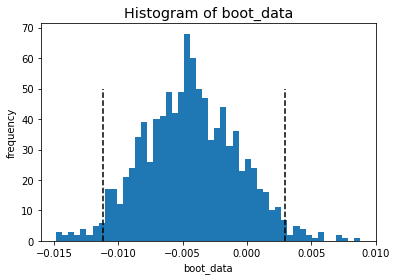

{'ci':               0
 0.025 -0.011172
 0.975  0.002940,
 'p_value': 0.23658729270829315}

In [36]:
get_bootstrap(a_group.payment, b_group.payment, statistic = cr_func)

Доверительный интервал **попадает в 0**, недостаточно оснований отвергнуть нулевую гипотезу. Нельзя утверждать, что различия CR в двух группах есть.

### ARPU
Сформулируем нулевую и альтернативную гипотезы:

* `H0`: ARPU в двух группах одинаковые.
* `H1`: ARPU в двух группах различаются.

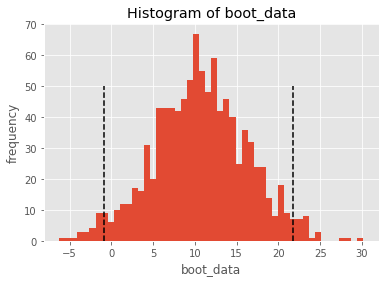

{'ci':                0
 0.025  -0.907882
 0.975  21.785250,
 'p_value': 0.054745019955063645}

In [37]:
get_bootstrap(a_group.rev, b_group.rev, statistic = arpu_func)

Доверительный интервал **не попадает в 0**, отвергаем нулевую гипотезу. ARPU в двух группах различаются.

### ARPPU
Сформулируем нулевую и альтернативную гипотезы:

* `H0`: ARPPU в двух группах одинаковые.
* `H1`: ARPPU в двух группах различаются.

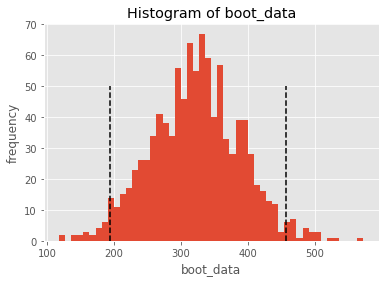

{'ci':                 0
 0.025  194.359962
 0.975  456.465537,
 'p_value': 1.2972090660317156e-06}

In [38]:
get_bootstrap(a_group.rev[a_group.rev > 0], b_group.rev[b_group.rev > 0], statistic = arppu_func)

Доверительный интервал **не попадает в 0**, отвергаем нулевую гипотезу. ARPPU в двух группах различаются.

### Стоит ли запускать новую механику на всех пользователей?
Да, новая механика оплаты даёт статистически значимый прирост в метриках ARPU и ARPPU, отрицательное изменение метрики CR не подтвердилось.

# Задание 2. SQL

## 2.1 Очень усердные ученики

Сопоставим все термины для понимания:

* карточки = задания = горошины,
* студент = ученик,
* усердный - 20 горошин (карточек / заданий) в месяц,
* очень усердный - 20 горошин (карточек / заданий) в час.

Ищем количетсво очень усердных студентов за март 2020, т.е. тех кто в течение марта 2020 смог выполнить хотя бы один раз 20 горошин в течение часа.

```sql
SELECT 
    COUNT(DISTINCT sq.st_id) AS hardworking_students          -- считаем количество отобранных уникальных студентов 
FROM (                                                        -- подзапрос
    SELECT  
        st_id, 
        timest,
        SUM(correct) OVER W AS peas_per_hour                  -- считаем кличество правильно решённых горошин в окне (в час)
    FROM peas
    WHERE 
        extract(Month from timest) = 3                        -- месяц = 3 (март)
        AND 
        extract(Year from timest) = 2020                      -- год = 2020
    WINDOW W AS (
            PARTITION BY st_id                                -- группируем по id студента
            ORDER BY timest                                   -- сортируем по времени
            RANGE BETWEEN '1 hour' PRECEDING AND CURRENT ROW) -- выбираем окно с 1 часа назад до текущей строки
    ) AS sq
WHERE sq.peas_per_hour >= 20                                  -- отбираем только тех где количество горошин в час >= 20
```

## 2.2 Оптимизация воронки
Активным будем считать тех, кто хотя бы раз выполнил 30 заданий в день. Т.е. те, кто столкнулся с лимитом выполнения задач.

* **ARPU** (Average Revenue Per User ) - отношение выручки к общему количеству пользователей.
* **ARPAU** (Average Revenue Per Active User) - отношение выручки к количеству активных пользователей.
* **CR в покупку** - отношение количества купивших пользователей к общему количеству пользователей.
* **СR активного пользователя в покупку** - отношение количества купивших активных пользователей к общему количеству активных пользователей.
* **CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике** - отношение количества купивших активных в математике пользователей к общему количеству активных в математике пользователей.

### План
1. Из таблицы `peas` получим список уникальных пользователей с отметками "0" или "1" об активности в целом.
2. Из таблицы `peas` получим список уникальных пользователей с отметками "0" или "1" об активности в математике.
3. Из таблицы `studs` получим данные о принадлежности пользователя к группе (test/control).
4. Из таблицы `checks` получим список оплативших пользователей со значениями "0" и "1" для купивших любой предмет и купивших математику.
5. Джойним 4 подзапроса.
6. Агрегируем полученные поля для подсчёта нужных метрик.

------------

### 1. Из таблицы `peas` получим список уникальных пользователей с отметками "0" или "1" об активности в целом.
```sql
(-- АКТИВНЫЕ ПОЛЬЗОВАТЕЛИ
SELECT actives.st_id, 
    MAX(CASE WHEN actives.peas_per_day >= 30 THEN 1 ELSE 0 END) AS active_in_total
FROM 
    (
    SELECT                                            -- считаем количество горошин в день 
        st_id, 
        timest, 
        SUM(correct) OVER W AS peas_per_day, 
        subject
    FROM peas 
    WINDOW W AS (
            PARTITION BY st_id                        -- группировка по студентам
            ORDER BY timest
            RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW
            ) 
    ) AS actives
GROUP BY st_id
) AS at
```

* В разделе `SELECT` используется конструкция `CASE WHEN actives.peas_per_day >= 30 THEN 1 ELSE 0 END` - это аналог `IF`, который позволяет в `SELECTe` заменять null-значения на 0.
* В подзапросе этого подзапроса в строке `SUM(correct) OVER W AS peas_per_day` мы с помощью окна `W` находим сумму правильно решёных задач. Т.к. поле `correct` содержит значения 0 для нерешённых и 1 для решённых, то такой запрос позволяет нам найти количество решённых задач в день.
* Параметры окна указываются после ключевого слова `WINDOW`. `PARTITION BY st_id` - группировать по студентам, `ORDER BY timest` - этот параметр одновременно и сортирует и указывает по какому полю будем брать окно, в данном случае - это время выполнения задачи.

### 2. Из таблицы `peas` получим список уникальных пользователей с отметками "0" или "1" об активности в математике.
```sql
(-- АКТИВНЫЕ ПОЛЬЗОВАТЕЛИ по математике
SELECT active_by_subj.st_id, 
    MAX(CASE WHEN active_by_subj.math_per_day >= 30 THEN 1 ELSE 0 END) AS active_in_math
FROM 
    (
    SELECT     -- считаем количество горошин в день по предметам
        st_id, 
        timest, 
        SUM(correct) OVER W2 AS math_per_day, 
        subject
    FROM peas 
    WINDOW W2 AS (
            PARTITION BY st_id, subject                       -- группировка по студентам  и предметам
            ORDER BY timest
            RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW
            ) 
    ) AS active_by_subj
```
Данный подзапрос аналогичен предыдущему.

### 3. Из таблицы `studs` получим данные о принадлежности пользователя к группе (test/control).
Здесь мы просто джойним таблицу `studs` без дополнительных преобразований.
```sql
JOIN 
    -- ОТМЕТКИ test / control
    studs     
ON at.st_id = studs.st_id
```

### 4. Из таблицы `checks` получим список оплативших пользователей со значениями "0" и "1" для купивших любой предмет и купивших математику.

```sql
--ПОКУПКА ЛЮБОГО ПРЕДМЕТА, ПОКУПКА МАТЕМАТИКИ
(
SELECT st_id, SUM(money) AS money,
    1 AS sale_subject,
    MAX(CASE WHEN subject = 'math' THEN 1 ELSE 0 END) AS sale_math
FROM checks 
GROUP BY st_id
) AS s
```

В этом подзапросе формируем две колонки, одна из которых `sale_subject` будет заполнена единицами, что говорит о совершении покупки пользователем (все единицы, т.к. это список купишвих пользователей, здесь нет других). Во второй `sale_math` - назначаем 1 пользователю купившему математику и 0 не купившему.

### 5. Джойним 4 подзапроса.
### 6. Агрегируем полученные поля для подсчёта нужных метрик.

#### Результирующий запрос
```sql
SELECT 
    studs.test_grp, 
    COALESCE(SUM(s.money), 0) / COUNT(at.st_id) AS ARPU,
    COALESCE(SUM(s.money), 0) / SUM(at.active_in_total) AS ARPAU,
    COALESCE(SUM(s.sale_subject), 0)::float / COUNT(at.st_id) AS CR,
    SUM(CASE WHEN at.active_in_total = 1 AND s.sale_subject = 1 THEN 1 ELSE 0 END)::float / SUM(at.active_in_total) AS СR_active,
    SUM(CASE WHEN am.active_in_math = 1 AND s.sale_math = 1 THEN 1 ELSE 0 END)::float / SUM(am.active_in_math) AS CR_math
FROM
    (-- АКТИВНЫЕ ПОЛЬЗОВАТЕЛИ
    SELECT actives.st_id, 
        MAX(CASE WHEN actives.peas_per_day >= 30 THEN 1 ELSE 0 END) AS active_in_total
    FROM 
        (
        SELECT     -- считаем количество горошин в день 
            st_id, 
            timest, 
            SUM(correct) OVER W AS peas_per_day, 
            subject
        FROM peas 
        WINDOW W AS (
                PARTITION BY st_id                        -- группировка по студентам
                ORDER BY timest
                RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW
                ) 
        ) AS actives
    GROUP BY st_id
    ) AS at
INNER JOIN
    (-- АКТИВНЫЕ ПОЛЬЗОВАТЕЛИ по математике
    SELECT active_by_subj.st_id, 
        MAX(CASE WHEN active_by_subj.math_per_day >= 30 THEN 1 ELSE 0 END) AS active_in_math
    FROM 
        (
        SELECT     -- считаем количество горошин в день по предметам
            st_id, 
            timest, 
            SUM(correct) OVER W2 AS math_per_day, 
            subject
        FROM peas 
        WINDOW W2 AS (
                PARTITION BY st_id, subject                       -- группировка по студентам  и предметам
                ORDER BY timest
                RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW
                ) 
        ) AS active_by_subj
    GROUP BY st_id
    ) AS am
ON at.st_id = am.st_id
INNER JOIN 
    -- отметки test / control
    studs     
ON at.st_id = studs.st_id
LEFT JOIN
    --покупка любого предмета, покупка математики
    (
    SELECT st_id, SUM(money) AS money,
        1 AS sale_subject,
        MAX(CASE WHEN subject = 'math' THEN 1 ELSE 0 END) AS sale_math
    FROM checks 
    GROUP BY st_id
    ) AS s
ON at.st_id = s.st_id
GROUP BY test_grp
```

#### Пояснения по блоку SELECT

```sql
1. studs.test_grp -- колонка со значением групп: test и control.
```
```sql
2. COALESCE(SUM(s.money), 0) / COUNT(at.st_id) AS ARPU -- функция COALESCE() позволяет в данном случае заменить null на 0 и корректно посчитать сумму.
```
```sql
3. COALESCE(SUM(s.money), 0) / SUM(at.active_in_total) AS ARPAU -- точно также, как и в предыдущем случае функция COALESCE() заменяет null на 0.
```
```sql
4. COALESCE(SUM(s.sale_subject), 0)::float / COUNT(at.st_id) AS CR -- точно также COALESCE() заменяет null на 0 и, т.к. и в числителе и в знаменателе целые числа, то и результат получается тоже целочисленным (в данном случае 0), чтобы исправить это переводим числитель во float (::float).
```
```sql
5. SUM(CASE WHEN at.active_in_total = 1 AND s.sale_subject = 1 THEN 1 ELSE 0 END)::float / SUM(at.active_in_total) AS СR_active -- здесь для отбора активных дополнительно используем конструкцию CASE END - это аналог IF. Для подсчёта СR_active отбираем только активных.
```
```sql
6. SUM(CASE WHEN am.active_in_math = 1 AND s.sale_math = 1 THEN 1 ELSE 0 END)::float / SUM(am.active_in_math) AS CR_math -- аналогичным образом отбираем только активных в математике.
```

# Задание 3. Python

Предположим, что у нас уже есть рабочий датафрейм:

In [39]:
# рабочий датафрэйм
total_test = (
    groups
    .merge(
        active_studs
            .assign(activity=1)
            .rename(columns={'student_id': 'id'})
        ,on='id', how='outer'
        )
    .merge(
        checks
            .assign(payment = 1)
            .rename(columns={'student_id': 'id'})
        ,on='id', how='outer'
    )
    .assign(step=0)
)
total_test.head()

,id,grp,activity,rev,payment,step
0,1489,B,NaN,NaN,NaN,0
1,1627,A,1.0,990.0,1.0,0
2,1768,B,NaN,NaN,NaN,0
3,1783,B,NaN,NaN,NaN,0
4,1794,A,NaN,NaN,NaN,0


У нас имеется ссылка на дополнительный файл (на Яндекс.Диске, или локально):

In [46]:
# ссылка на дополнительный файл
add_csv_link = 'https://disk.yandex.ru/d/X0T1LNLKgEe9lw'
# или add_csv_link = 'group_add.csv'

Напишем несколько вспомогательных функций:

In [47]:
# выделяем активных, заполняем пропуски нулями
def get_active(df, to_dropna_ls=['activity', 'grp'], to_fillna_ls=['payment', 'rev']):
    '''
    df - датафрейм
    to_dropna_ls - указываем список колонок датафрэйма, по которым удаляем строки с NaN
    to_fillna_ls - указываем список колонок датафрэйма, по которым NaN заполняем нулями 
    '''
    df = (df
         .copy()
         .dropna(subset=to_dropna_ls)
         )
    for i in to_fillna_ls:
        df[i] = df[i].fillna(0)
    return df


# определяем разделитель в csv-файле
def get_sep(file_link):
    with open(file_link, 'r') as file:
        temp = file.readline()
    pattern = re.compile(r'\w*([,;])\w*')
    return pattern.findall(temp)[0]


# переименовываем колонки в соответствие с типом данных
def columns_renamer(df):
    if str(df.iloc[0, 0]).isalpha():
        df.columns = ['grp', 'id']
    else:
        df.columns = ['id', 'grp']

Далее, напишем функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` и пересчитывать метрики:

In [48]:
def get_update(work_df, add_csv_link, final=False):
    '''
    Функция обновления данных и пересчёта метрик.
    На выходе поучаем датафрэйм со значениями метрик и p-value, 
    каждая строка - новый степ добавления данных (номер обновления показан в колонке step, 
    шаг 0 - значения без доп. файла/обновления)
    work_df       - объединённый дф из groups.csv, active_studs.csv, checks.csv (получены в первый раз).
    add_csv_link  - ссылка на дополнительный файл groups_add.csv, 
                    возможно использование web-ссылки на Яндекс.Диск, или ссылки на файл в файловой системе.
    final         - если True, выведет только последнюю (финальную) строку таблицы.
    '''
    if add_csv_link.startswith('https://'):

        # скачиваем дополнительный файл
        final_url    = base_url + urlencode(dict(public_key=add_csv_link))
        response     = requests.get(final_url)
        download_url = response.json()['href']
        group_add_df = pd.read_csv(download_url, sep=',')

        # загружаем файл и сохраняем его
        download_response = requests.get(download_url)
        with open('group_add.csv', 'wb') as f:
            f.write(download_response.content)

        # открываем файл
        group_add_df = pd.read_csv('group_add.csv', sep=get_sep('group_add.csv'))

    else:
        # открываем файл
        group_add_df = pd.read_csv(add_csv_link, sep=get_sep(add_csv_link))

    # переименуем колонки в соответствие с типом данных
    columns_renamer(group_add_df)
    
    # объединяем основной дф с дополнительным
    work_df          = work_df.merge(group_add_df, on='id', how='outer')
    work_df['grp_x'] = work_df.grp_x.fillna('')                  # заполняем пропуски пустым символом
    work_df['grp_y'] = work_df.grp_y.fillna('')                  # заполняем пропуски пустым символом
    work_df['grp']   = work_df.grp_x + work_df.grp_y             # объединяем колонки групп
    work_df          = work_df.drop(['grp_x', 'grp_y'], axis=1)  # удаляем колонки grp_x и grp_y
    
    # присваиваем значения step в добавленных строках
    mask = work_df.id.isin(group_add_df.id)             # назначаем маску, согласно которой будем присваивать новый номер степа
    work_df.loc[mask, 'step'] = work_df.step.max() + 1  # присваиваем номер степа
    work_df['step'] = work_df.step.astype('int')        # переводим колонку степ в int

    # оставим только активных
    work_df = get_active(work_df)
    
    # пересчитаем метрики, каждый цикл - новое добавление файла groups_add
    df_ab = pd.DataFrame()  # пустой дф для заполнения через цикл

    for i in range(work_df.step.max() + 1):  # итеритуемся по максимальному значению колонки step +1
        # фильтруем датасет для рассчёта метрик
        payment_a      = work_df.query('step <= @i and grp =="A"').payment               
        payment_b      = work_df.query('step <= @i and grp =="B"').payment
        rev_all_a      = work_df.query('step <= @i and grp =="A"').rev
        rev_all_b      = work_df.query('step <= @i and grp =="B"').rev
        rev_positive_a = work_df.query('step <= @i and rev > 0 and grp =="A"').rev
        rev_positive_b = work_df.query('step <= @i and rev > 0 and grp =="B"').rev

        #CR_a
        cr_a = cr_func(payment_a)
        #CR_b
        cr_b = cr_func(payment_b)
        #CR p-value
        cr_p_value = get_bootstrap(payment_a, 
                                   payment_b,
                                   statistic=cr_func,
                                   graph = False,
                                   show_progress = False
                     )["p_value"]
        #ARPU_a
        arpu_a = arpu_func(rev_all_a)
        #ARPU_b
        arpu_b = arpu_func(rev_all_b)
        #ARPU p-value
        arpu_p_value = get_bootstrap(rev_all_a, 
                                     rev_all_b,
                                     statistic=arpu_func,
                                     graph = False,
                                     show_progress = False
                       )["p_value"]
        #ARPPU_a
        arppu_a       = arppu_func(rev_positive_a)
        #ARPPU_b
        arppu_b       = arppu_func(rev_positive_b)
        #ARPPU p-value
        arppu_p_value = get_bootstrap(rev_positive_a,
                                      rev_positive_b,
                                      statistic=arppu_func,
                                      graph = False,
                                      show_progress = False
                        )["p_value"]

        # временный датафрэйм
        temp_df = pd.DataFrame([[cr_a, 
                                 cr_b, 
                                 cr_p_value, 
                                 arpu_a, 
                                 arpu_b, 
                                 arpu_p_value, 
                                 arppu_a, 
                                 arppu_b, 
                                 arppu_p_value]],
                               columns=['CR_A',
                                        'CR_B',
                                        'CR_p-value',
                                        'ARPU_A',
                                        'ARPU_B',
                                        'ARPU_p-value', 
                                        'ARPPU_A',
                                        'ARPPU_B',
                                        'ARPPU_p-value'])
        # добавляем строку в итоговый дф
        df_ab = pd.concat([df_ab, temp_df])      
    
    # сбрасываем индексы
    df_ab.reset_index(drop=True, inplace=True)  
    df_ab['step'] = df_ab.index
    
    if final == True:
        return df_ab.tail(1)
    
    return df_ab

В функцию `get_update` передадим предварительно сформированный датафрейм `total_test`:

In [49]:
metrix = get_update(total_test, add_csv_link)
metrix

,CR_A,CR_B,CR_p-value,ARPU_A,ARPU_B,ARPU_p-value,ARPPU_A,ARPPU_B,ARPPU_p-value,step
0,0.050814,0.046077,0.207359,47.439739,57.864567,0.045236,933.589744,1255.827487,0.000004,0
1,0.050715,0.046156,0.215245,47.347204,58.058798,0.037753,933.589744,1257.878992,0.000003,1


Напишем функцию отрисовки графиков:

In [50]:
def get_graphs(df):
    '''
    Функция построения графика на основе датасэта, сформированного функцией get_update
    Шесть графиков: 
    по оси X - номер обновления (колонка step в передаваемом дф), показывает 
    какой раз обновились данные (некий аналог временной шкалы, т.к. не известны даты создания 
    дополнительных файлов)
    по оси Y - метрики (верхний ряд графиков) и p-value этих метрик (нижний ряд графиков)
    '''
    # формируем датафрэйм для отрисовки метрик
    metrix_df = pd.DataFrame(columns = ['step', 'group'])                     # создаём пустой финальный дф для построения графиков метрик
    for i in ['CR_', 'ARPU_', 'ARPPU_']:                                      # список части названий колонок для отбора
        cols    = df.filter(like = i).columns                                 # отбираем колонки содержащие названия метрик
        temp_df = pd.DataFrame()                                              # создаём пустой дф
        for j in cols[:2]:                                                    # итерируемся по названиям колонок, кроме p-value
            tmp_row         = df[[j, 'step']] \
            .assign(group = j[-1:]) \
            .rename(columns = {j: j[:-2]})  # формируем строку нового дф
            temp_df         = pd.concat([temp_df, tmp_row])                   # добавляем строку в промежуточный дф
        metrix_df = metrix_df \
                    .merge(temp_df, on=['step', 'group'], how='right')        # объединяем промежуточный дф с финальным
    
    # формируем блок из 6 графиков
    figure, axes = plt.subplots(2, 3, sharex=True, figsize=(16,7))   
    
    # заголовок
    figure.suptitle('Метрики и p-value', fontsize=20)
    
    # графики CR и p-value для CR
    sns.lineplot(ax=axes[0, 0], data=metrix_df, x='step', y='CR', hue='group', linewidth=2)
    ax1 = sns.lineplot(ax=axes[1, 0], data=df, x='step', y='CR_p-value', linewidth=2, color="#5fa0c6", label='p-value')
    ax1.axhline(0.05, ls='--', linewidth=1.5, color=(1, 0, 0, 0.7), label='p-value = 0.05')
    ax1.set_ylabel('P-value для CR')
    ax1.set_xlabel('Номер обновления')
    ax1.legend()
    
    # графики ARPU и p-value для ARPU
    sns.lineplot(ax=axes[0, 1], data=metrix_df, x='step', y='ARPU', hue='group', linewidth=2)
    ax2 = sns.lineplot(ax=axes[1, 1], data=df, x='step', y='ARPU_p-value', linewidth=2, color="#5fa0c6", label='p-value')
    ax2.axhline(0.05, ls='--', linewidth=1.5, color=(1, 0, 0, 0.7), label='p-value = 0.05')
    ax2.set_ylabel('P-value для ARPU')
    ax2.set_xlabel('Номер обновления')
    ax2.legend()
    
    # графики ARPPU и p-value для ARPPU
    sns.lineplot(ax=axes[0, 2], data=metrix_df, x='step', y='ARPPU', hue='group', linewidth=2)
    ax3 = sns.lineplot(ax=axes[1, 2], data=df, x='step', y='ARPPU_p-value', linewidth=2, color="#5fa0c6", label='p-value')
    ax3.axhline(0.05, ls='--', linewidth=1.5, color=(1, 0, 0, 0.7), label='p-value = 0.05')
    ax3.set_ylabel('P-value для ARPPU ')
    ax3.set_xlabel('Номер обновления')
    ax3.set_xticks(range(0, metrix_df.step.max() + 1))  # сделаем шаг по оси х = 1
    ax3.legend()
    
    # устанавливаем лимиты на ось y
    plt.gcf().get_axes()[0].set_ylim(0, metrix_df.CR.max() * 1.1)                  
    plt.gcf().get_axes()[1].set_ylim(0, metrix_df.ARPU.max() * 1.1)
    plt.gcf().get_axes()[2].set_ylim(0, metrix_df.ARPPU.max() * 1.1)
    plt.gcf().get_axes()[3].set_ylim(-0.001, max(0.05, metrix['CR_p-value'].max()) * 1.1)
    plt.gcf().get_axes()[4].set_ylim(-0.001, max(0.05, metrix['ARPU_p-value'].max()) * 1.1)
    plt.gcf().get_axes()[5].set_ylim(-0.001, max(0.05, metrix['ARPPU_p-value'].max()) * 1.1)
    
    # добавляем расстояния между графиками
    plt.subplots_adjust(top=0.92, hspace = 0.1, wspace=0.3)

В функцию `get_graphs` передадим метрики, записанные в переменную `metrix`:

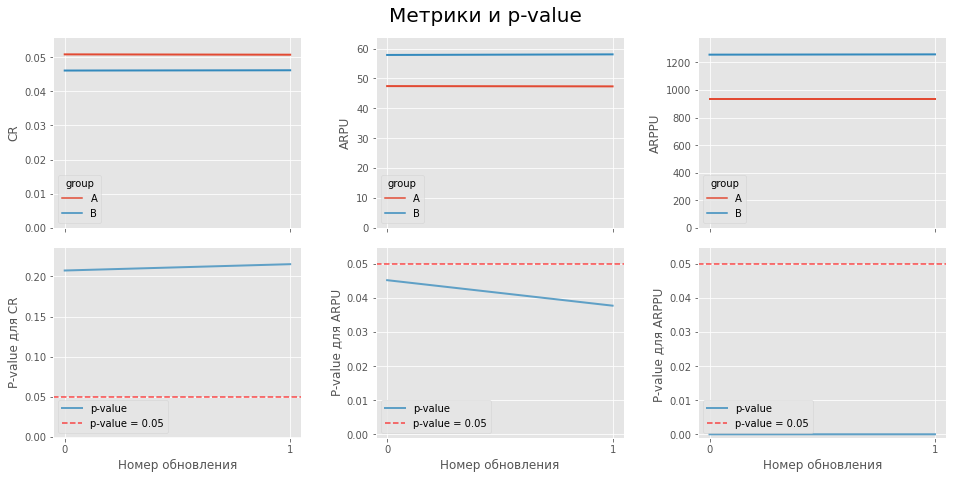

In [51]:
get_graphs(metrix)

Таким образом, используя функции `get_update` и `get_graphs` мы можем в несколько кликов получить метрики и графики с учетом новых данных.